## This repository contains an end-to-end pipeline for developing an NLP model (text classifier) that categorizes complaints based on victim, type of fraud, and other relevant parameters. 

## The code contains the following necessary steps:

- **Text Preprocessing**: Tokenization, stop word removal, stemming, and text cleaning to prepare data.
- **Model Development**: Selection of a suitable NLP model for text classification. The following models are explored: Naive Bayes, Random Forrest, XGBoost, SVM (RBF), SVM (polynomial), DistilBERT Model. 

- **Accuracy Measurement**: Evaluate the model based on metrics such as accuracy, precision, recall, and F1-score.


In [53]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/ec.gpu/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/ec.gpu/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/ec.gpu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/ec.gpu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/ec.gpu/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_dat

# Loading the train and test sets

In [54]:
data = pd.read_csv("train.csv", encoding="ISO-8859-1")
test = pd.read_csv("test.csv")
data = data.rename(columns={'crimeaditionalinfo': 'text'})
data = data.dropna(subset=['text'])

In [55]:
test = test.rename(columns={'crimeaditionalinfo': 'text'}) # renaming the crime info column
test = test.dropna(subset=['text']) # dropping all entries with no information on the crime

# EDA and Preprocessing starts...

# Cleaning nulls in text entry

In [56]:
null_count = data['sub_category'].isnull().sum()
data['sub_category'].fillna(data['category'], inplace=True)
test['sub_category'].fillna(data['category'], inplace=True) # replacing the null entries in sub_category column with the category of the complaint
print('null count: ', null_count)

null count:  6591


/tmp/ipykernel_3861673/3101272462.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sub_category'].fillna(data['category'], inplace=True)
/tmp/ipykernel_3861673/3101272462.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [57]:
data.groupby('category')['sub_category'].value_counts() # number of entries and sub categories under each categories

category                                              sub_category                                                        
Any Other Cyber Crime                                 Other                                                                   10877
Child Pornography CPChild Sexual Abuse Material CSAM  Child Pornography CPChild Sexual Abuse Material CSAM                      379
Cryptocurrency Crime                                  Cryptocurrency Fraud                                                      480
Cyber Attack/ Dependent Crimes                        Hacking/Defacement                                                        540
                                                      Ransomware Attack                                                         534
                                                      Malware Attack                                                            521
                                                      Tampering with computer source 

#  Mapping sub categories to respective categories

In [58]:
mapping = data.set_index('sub_category')['category'].to_dict()
def get_category(sub_category):
    return mapping.get(sub_category)
subcategories = data['sub_category'].unique().tolist()

print(get_category('Cryptocurrency Fraud')) # Example usecase

Cryptocurrency Crime


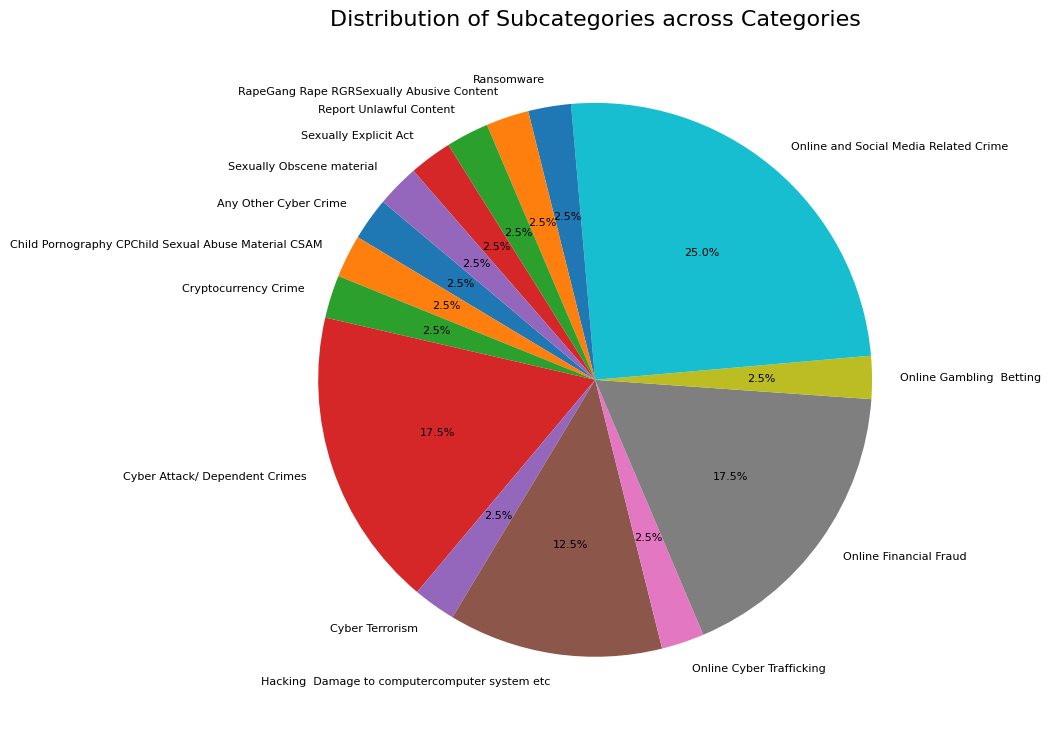

In [59]:
subcat_count = data.groupby('category')['sub_category'].nunique()
plt.figure(figsize=(10, 8))
plt.pie(subcat_count, labels=subcat_count.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 8})
plt.title("Distribution of Subcategories across Categories", fontsize=16)
plt.tight_layout(pad=3)
plt.show()

# Unique categories in train and test data

## Some categories and sub categories are unique to test and train data which cannot be classified on evaluation

In [60]:
unique_data_subcategories = set(data['sub_category'].unique())
unique_test_subcategories = set(test['sub_category'].unique())

exclusive_in_data_subcategories = unique_data_subcategories - unique_test_subcategories
exclusive_in_test_subcategories = unique_test_subcategories - unique_data_subcategories

print("Subcategories exclusive to 'train' dataframe:")
print(list(exclusive_in_data_subcategories))
print("\nSubcategories exclusive to 'test' dataframe:")
print(list(exclusive_in_test_subcategories))


Subcategories exclusive to 'train' dataframe:
['Against Interest of sovereignty or integrity of India']

Subcategories exclusive to 'test' dataframe:
['Hacking  Damage to computercomputer system etc', 'Cryptocurrency Crime', 'Any Other Cyber Crime', 'Online Financial Fraud', 'Cyber Blackmailing & Threatening', 'Computer Generated CSAM/CSEM', 'Online and Social Media Related Crime', 'Cyber Attack/ Dependent Crimes', 'Sexual Harassment', 'Online Cyber Trafficking']


In [61]:
exclusive_in_test_subcategories

{'Any Other Cyber Crime',
 'Computer Generated CSAM/CSEM',
 'Cryptocurrency Crime',
 'Cyber Attack/ Dependent Crimes',
 'Cyber Blackmailing & Threatening',
 'Hacking  Damage to computercomputer system etc',
 'Online Cyber Trafficking',
 'Online Financial Fraud',
 'Online and Social Media Related Crime',
 'Sexual Harassment'}

In [62]:
unique_data_categories = set(data['category'].unique())
unique_test_categories = set(test['category'].unique())

exclusive_in_data = unique_data_categories - unique_test_categories
exclusive_in_test = unique_test_categories - unique_data_categories

exclusive_in_data, exclusive_in_test


({'Report Unlawful Content'}, {'Crime Against Women & Children'})

## Distribution of character and word counts

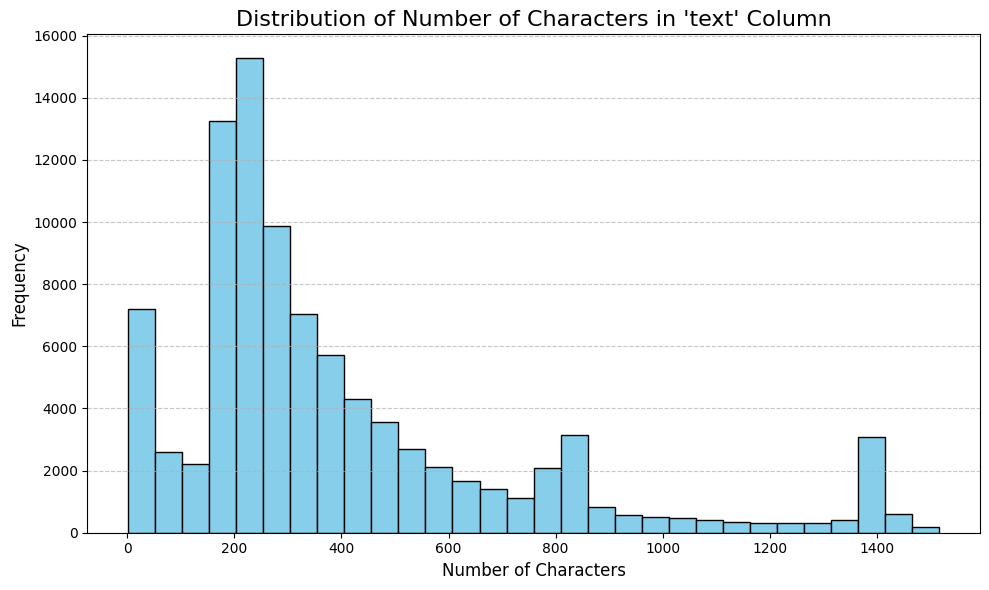

In [63]:
data['char_count'] = data['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(data['char_count'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Number of Characters in 'text' Column", fontsize=16)
plt.xlabel("Number of Characters", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


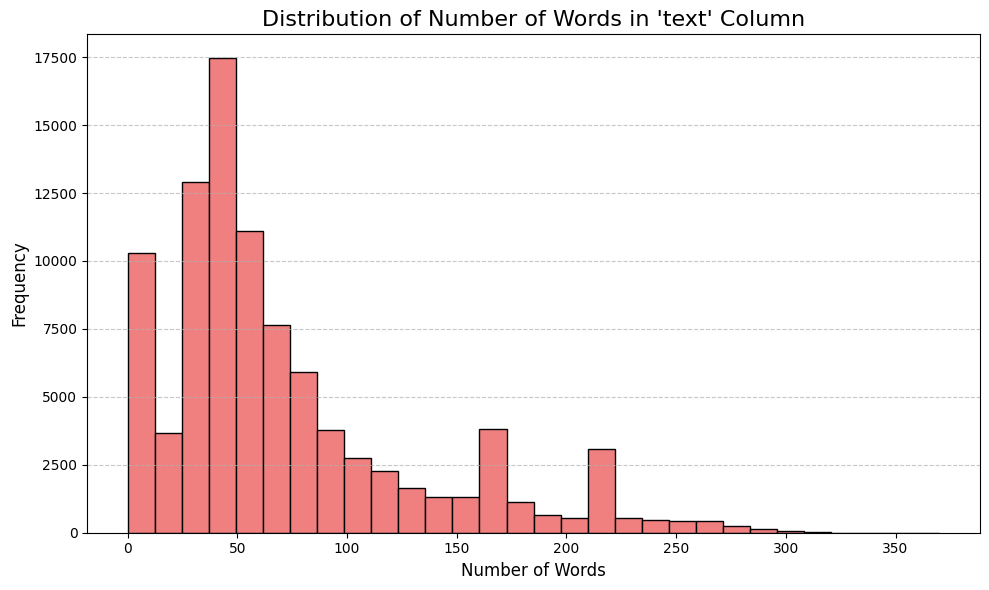

In [64]:
data['word_count'] = data['text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(10, 6))
plt.hist(data['word_count'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Distribution of Number of Words in 'text' Column", fontsize=16)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Cleaning under-informed entries
From the above distributions it is clear that some complaints have less than ideal information in order to classify it, hence the complaints with less than 4 words have been removed.

In [65]:
data = data[data['word_count'] >= 4]
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].str.lower().apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
test['text'] = test['text'].str.lower().apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [66]:
# Removing all instances which are not of type string
data = data[data['text'].apply(lambda x: isinstance(x, str))]
test = test[test['text'].apply(lambda x: isinstance(x, str))]
total_char_count = data['text'].str.len().sum()
total_char_count

np.int64(26320547)

## Text cleaning and normalization
Input text is converted to lowercase, punctuation, digits, URLs, and newline characters are removed. The text is tokenized, stopwords (except "not") are removed, and the remaining words are lemmatized.



In [67]:
def Text_Cleaning(Text):
  Text = Text.lower()
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)
  Text = re.sub(r'\d+', '', Text)
  Text = re.sub('https?://\S+|www\.\S+', '', Text)
  Text = re.sub('\n', '', Text)
  return Text
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
    Processed_Text = list()
    Lemmatizer = WordNetLemmatizer()
    Tokens = nltk.word_tokenize(Text)

    for word in Tokens:
        if word not in Stopwords:
            Processed_Text.append(Lemmatizer.lemmatize(word))

    return " ".join(Processed_Text)

In [68]:
data["text"] = data["text"].apply(lambda Text: Text_Cleaning(Text))
test["text"] = test["text"].apply(lambda Text: Text_Cleaning(Text))
data["text"] = data["text"].apply(lambda Text: Text_Processing(Text))
test["text"] = test["text"].apply(lambda Text: Text_Processing(Text))

In [69]:
total_char_count = data['text'].str.len().sum()
total_char_count

np.int64(25920201)

## For further processing stemming is applied to normalize the lemmatized text

In [70]:
stemmer = PorterStemmer()
data['text'] = data['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x)]))
test['text'] = test['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(x)]))

In [71]:
data.to_csv('stemmed_train.csv', index=False)
test.to_csv('stemmed_test.csv', index=False)

## Load pre-processed dataset

In [72]:
data=pd.read_csv("stemmed_train.csv")
test= pd.read_csv("stemmed_test.csv")
data = data[data['text'].apply(lambda x: isinstance(x, str))]
test = test[test['text'].apply(lambda x: isinstance(x, str))]

## Creating label encoder and decoder

In [73]:
le = LabelEncoder()
y = le.fit_transform(data['sub_category'])

def decode_sub_category(encoded_value):
    return le.inverse_transform([encoded_value])[0]
print(decode_sub_category(4))

Cryptocurrency Fraud


In [74]:
N_CLASS=y.max()+1 # number of sub_categories present in data
N_CLASS

np.int64(39)

# Word embedding

Bag of Words and TFIDF(Term Frequency-Inverse Document Frequency) has been applied

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(2, 2))
#Creating tfidf vectors for train and test data

tfidf_data = tfidf_vectorizer.fit_transform(data['text'])
bow_data = bow_vectorizer.fit_transform(data['text'])

tfidf_test = tfidf_vectorizer.transform(test['text'])
bow_test = bow_vectorizer.transform(test['text'])

#joblib.dump(tfidf_data, 'tfidf_data_embeddings.pkl')
#joblib.dump(bow_data, 'bow_data_embeddings.pkl')
#joblib.dump(tfidf_test, 'tfidf_test_embeddings.pkl')
#joblib.dump(bow_test, 'bow_test_embeddings.pkl')

In [99]:
data

,category,sub_category,text,char_count,word_count
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,continu receiv random call abus messag whatsap...,258,46
1,Online Financial Fraud,Fraud CallVishing,fraudster continu messag ask pay money send fa...,247,45
2,Online Gambling Betting,Online Gambling Betting,act like polic demand money ad section text me...,229,40
3,Online and Social Media Related Crime,Online Job Fraud,apna job appli job interview telecal resourc m...,538,98
4,Online Financial Fraud,Fraud CallVishing,receiv call ladi state send new phone vivo rec...,194,37
...,...,...,...,...,...
87604,Online Financial Fraud,Internet Banking Related Fraud,ident theft smish sm fraud creditdebit card fr...,274,42
87605,Online Financial Fraud,EWallet Related Fraud,receiv call number ask phone pay cash back off...,195,34
87606,Online Financial Fraud,UPI Related Frauds,cyber stalk blackmail phonesmsvoip call victim...,212,33
87607,Online and Social Media Related Crime,Online Matrimonial Fraud,call kark bola ki aapka lotari laga ha aru ac ...,231,48


## Model Creation and evaluation

### Due to the loss of semantic information in vectorization techniques such as TFIDF or Bag of Words, common ML models are used to classify the data

In [110]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [111]:
# import pickle


# with open('tfidf_data_embeddings.pkl', 'rb') as f:
#     tfidf_data = pickle.load(f)
# with open('bow_data_embeddings.pkl', 'rb') as f:
#     bow_data = pickle.load(f)
# with open('tfidf_test_embeddings.pkl', 'rb') as f:
#     tfidf_test = pickle.load(f)
# with open('bow_test_embeddings.pkl', 'rb') as f:
#     tfidf_test = pickle.load(f)


Multinomial Naive Bayes classifier

In [112]:
nb_tfidf = MultinomialNB().fit(tfidf_data, y)
nb_bow = MultinomialNB().fit(bow_data, y)

In [113]:
nb_tfidf_predictions = nb_tfidf.predict(tfidf_test)
nb_bow_predictions = nb_bow.predict(bow_test)

Random Forest classifier

In [ ]:
rf_tfidf = RandomForestClassifier().fit(tfidf_data, y)
rf_bow = RandomForestClassifier().fit(bow_data, y)

In [ ]:
rf_tfidf_predictions = rf_tfidf.predict(tfidf_test)
rf_bow_predictions = rf_bow.predict(bow_test)

### Function for evaluating model performance
The model performance is evaluated on basis of subcategory and category classification in the following way:


1.   Decode the predicted labels to find predicted subcategories
2.   Evaluate by comparing to subcategory entries in test dataset
3.   Map the predicted subcategory to its original category
4.   Evaluate by comparing to category entries in test dataset





In [ ]:
def evaluate_predictions(label_encoded_predictions, test_data, sub_to_category_map):
    decoded_sub_categories = [decode_sub_category(pred) for pred in label_encoded_predictions]

    sub_category_matches = [pred == actual for pred, actual in zip(decoded_sub_categories, test_data['sub_category'])]
    sub_category_accuracy = sum(sub_category_matches) / len(sub_category_matches)

    predicted_categories = [sub_to_category_map[sub] for sub in decoded_sub_categories] # Retrieve category from mapping
    category_matches = [pred == actual for pred, actual in zip(predicted_categories, test_data['category'])]
    category_accuracy = sum(category_matches) / len(category_matches)

    return sub_category_accuracy, category_accuracy

In [ ]:
nb_tfidf_subcat_acc, nb_tfidf_cat_acc = evaluate_predictions(nb_tfidf_predictions, test, mapping)
nb_bow_subcat_acc, nb_bow_cat_acc = evaluate_predictions(nb_bow_predictions, test, mapping)
print("NB TF-IDF - Subcategory Accuracy:", nb_tfidf_subcat_acc)
print("NB TF-IDF - Category Accuracy:", nb_tfidf_cat_acc)
print("NB BOW - Subcategory Accuracy:", nb_bow_subcat_acc)
print("NB BOW - Category Accuracy:", nb_bow_cat_acc)

NB TF-IDF - Subcategory Accuracy: 0.4605980023349332
NB TF-IDF - Category Accuracy: 0.6917563886366584
NB BOW - Subcategory Accuracy: 0.41675314567388766
NB BOW - Category Accuracy: 0.6846218705409262


In [ ]:
rf_tfidf_subcat_acc, rf_tfidf_cat_acc = evaluate_predictions(rf_tfidf_predictions, test, mapping)
rf_bow_subcat_acc, rf_bow_cat_acc = evaluate_predictions(rf_bow_predictions, test, mapping)

print("RF TF-IDF - Subcategory Accuracy:", rf_tfidf_subcat_acc)
print("RF TF-IDF - Category Accuracy:", rf_tfidf_cat_acc)
print("RF BOW - Subcategory Accuracy:", rf_bow_subcat_acc)
print("RF BOW - Category Accuracy:", rf_bow_cat_acc)

RF TF-IDF - Subcategory Accuracy: 0.4878388896095473
RF TF-IDF - Category Accuracy: 0.7243805941107796
RF BOW - Subcategory Accuracy: 0.4799909197042418
RF BOW - Category Accuracy: 0.7192891425606434


## Polynomial Support Vector Machine

In [ ]:
# SVC Polynomial Kernel
svc_poly = SVC(kernel='poly', probability=True)
svc_poly.fit(tfidf_data, y)
svc_poly_tfidf_predictions = svc_poly.predict(tfidf_test)

svc_poly.fit(bow_data, y)
svc_poly_bow_predictions = svc_poly.predict(bow_test)

svc_poly_tfidf_subcat_acc, svc_poly_tfidf_cat_acc = evaluate_predictions(svc_poly_tfidf_predictions, test, mapping)
svc_poly_bow_subcat_acc, svc_poly_bow_cat_acc = evaluate_predictions(svc_poly_bow_predictions, test, mapping)

print("SVC Polynomial TF-IDF - Subcategory Accuracy:", svc_poly_tfidf_subcat_acc)
print("SVC Polynomial TF-IDF - Category Accuracy:", svc_poly_tfidf_cat_acc)
print("SVC Polynomial BOW - Subcategory Accuracy:", svc_poly_bow_subcat_acc)
print("SVC Polynomial BOW - Category Accuracy:", svc_poly_bow_cat_acc)


## Radial Basis function kernel SVM

In [ ]:
# SVC RBF Kernel
svc_rbf = SVC(kernel='rbf', probability=True)
svc_rbf.fit(tfidf_data, y)
svc_rbf_tfidf_predictions = svc_rbf.predict(tfidf_test)

svc_rbf.fit(bow_data, y)
svc_rbf_bow_predictions = svc_rbf.predict(bow_test)

svc_rbf_tfidf_subcat_acc, svc_rbf_tfidf_cat_acc = evaluate_predictions(svc_rbf_tfidf_predictions, test, mapping)
svc_rbf_bow_subcat_acc, svc_rbf_bow_cat_acc = evaluate_predictions(svc_rbf_bow_predictions, test, mapping)

print("SVC RBF TF-IDF - Subcategory Accuracy:", svc_rbf_tfidf_subcat_acc)
print("SVC RBF TF-IDF - Category Accuracy:", svc_rbf_tfidf_cat_acc)
print("SVC RBF BOW - Subcategory Accuracy:", svc_rbf_bow_subcat_acc)
print("SVC RBF BOW - Category Accuracy:", svc_rbf_bow_cat_acc)


## Gradient Boosting classifier

In [84]:
# XGBoost
xgb_model = XGBClassifier(device="cuda")
xgb_model.fit(tfidf_data, y)
xgb_tfidf_predictions = xgb_model.predict(tfidf_test)

xgb_model.fit(bow_data, y)
xgb_bow_predictions = xgb_model.predict(bow_test)

xgb_tfidf_subcat_acc, xgb_tfidf_cat_acc = evaluate_predictions(xgb_tfidf_predictions, test, mapping)
xgb_bow_subcat_acc, xgb_bow_cat_acc = evaluate_predictions(xgb_bow_predictions, test, mapping)

print("XGBoost TF-IDF - Subcategory Accuracy:", xgb_tfidf_subcat_acc)
print("XGBoost TF-IDF - Category Accuracy:", xgb_tfidf_cat_acc)
print("XGBoost BOW - Subcategory Accuracy:", xgb_bow_subcat_acc)
print("XGBoost BOW - Category Accuracy:", xgb_bow_cat_acc)


/home/ec.gpu/miniconda3/envs/nlp_indiaAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:35:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost TF-IDF - Subcategory Accuracy: 0.043455701128551044
XGBoost TF-IDF - Category Accuracy: 0.13182643663250745
XGBoost BOW - Subcategory Accuracy: 0.043715138150214036
XGBoost BOW - Category Accuracy: 0.13241016993124918


# Overall classification metrics

In [91]:
import warnings
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=UserWarning)
le = LabelEncoder()
y = le.fit_transform(data['sub_category'])

def decode_sub_category(encoded_value):
    return le.inverse_transform([encoded_value])[0]
def classification_metrics(label_encoded_predictions, test_data, sub_to_category_map):
    decoded_sub_categories = [decode_sub_category(pred) for pred in label_encoded_predictions]
    combined_sub_labels = np.concatenate((decoded_sub_categories, test_data['sub_category']))
    le_sub_combined = LabelEncoder().fit(combined_sub_labels) # New encoder for the extra classes in test data

    encoded_decoded_sub_categories = le_sub_combined.transform(decoded_sub_categories)
    encoded_test_sub_categories = le_sub_combined.transform(test_data['sub_category'])

    sub_category_accuracy = accuracy_score(encoded_test_sub_categories, encoded_decoded_sub_categories)
    sub_category_f1 = f1_score(encoded_test_sub_categories, encoded_decoded_sub_categories, average='weighted', zero_division=0)
    sub_category_precision = precision_score(encoded_test_sub_categories, encoded_decoded_sub_categories, average='weighted', zero_division=0)
    sub_category_recall = recall_score(encoded_test_sub_categories, encoded_decoded_sub_categories, average='weighted', zero_division=0)

    print("Subcategory Metrics:")
    print(f"Accuracy: {sub_category_accuracy}")
    print(f"F1 Score: {sub_category_f1}")
    print(f"Precision: {sub_category_precision}")
    print(f"Recall: {sub_category_recall}")

    predicted_categories = [sub_to_category_map[sub] for sub in decoded_sub_categories]
    combined_cat_labels = np.concatenate((predicted_categories, test_data['category']))
    le_cat_combined = LabelEncoder().fit(combined_cat_labels)

    encoded_predicted_categories = le_cat_combined.transform(predicted_categories)
    encoded_test_categories = le_cat_combined.transform(test_data['category'])

    category_accuracy = accuracy_score(encoded_test_categories, encoded_predicted_categories)
    category_f1 = f1_score(encoded_test_categories, encoded_predicted_categories, average='weighted', zero_division=0)
    category_precision = precision_score(encoded_test_categories, encoded_predicted_categories, average='weighted', zero_division=0)
    category_recall = recall_score(encoded_test_categories, encoded_predicted_categories, average='weighted', zero_division=0)

    print("\nCategory Metrics:")
    print(f"Accuracy: {category_accuracy}")
    print(f"F1 Score: {category_f1}")
    print(f"Precision: {category_precision}")
    print(f"Recall: {category_recall}")





In [ ]:


print('Naive Bayes tfidf metrics')
classification_metrics(nb_tfidf_predictions, test, mapping)

print('\nNaive Bayes BoW metrics')
classification_metrics(nb_bow_predictions, test, mapping)

print('\nRandom Forest tfidf metrics')
classification_metrics(rf_tfidf_predictions, test, mapping)

print('\nRandom Forest BoW metrics')
classification_metrics(rf_bow_predictions, test, mapping)

print('\nSVC Polynomial tfidf metrics')
classification_metrics(svc_poly_tfidf_predictions, test, mapping)

print('\nSVC Polynomial BoW metrics')
classification_metrics(svc_poly_bow_predictions, test, mapping)

print('\nSVC RBF tfidf metrics')
classification_metrics(svc_rbf_tfidf_predictions, test, mapping)

print('\nSVC RBF BoW metrics')
classification_metrics(svc_rbf_bow_predictions, test, mapping)

print('\nXGBoost tfidf metrics')
classification_metrics(xgb_tfidf_predictions, test, mapping)

print('\nXGBoost BoW metrics')
classification_metrics(xgb_bow_predictions, test, mapping)

In [92]:
print('\nXGBoost tfidf metrics')
classification_metrics(xgb_tfidf_predictions, test, mapping)

print('\nXGBoost BoW metrics')
classification_metrics(xgb_bow_predictions, test, mapping)


XGBoost tfidf metrics
Subcategory Metrics:
Accuracy: 0.043455701128551044
F1 Score: 0.003619507677291049
Precision: 0.0018883979605739524
Recall: 0.043455701128551044

Category Metrics:
Accuracy: 0.13182643663250745
F1 Score: 0.03070825849752975
Precision: 0.017378209395224505
Recall: 0.13182643663250745

XGBoost BoW metrics
Subcategory Metrics:
Accuracy: 0.043715138150214036
F1 Score: 0.004945154684446436
Precision: 0.09506838830746173
Recall: 0.043715138150214036

Category Metrics:
Accuracy: 0.13241016993124918
F1 Score: 0.033194080346415175
Precision: 0.3896788584344145
Recall: 0.13241016993124918


## LSTM model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec


# Step 1: Tokenize and prepare the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, padding='post')

# Step 2: Convert categories to labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['category'])

# Step 3: Train a Word2Vec model on the text data
# Tokenize and create a list of words
texts = [text.split() for text in data['text']]
w2v_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

# Get Word2Vec embeddings for the words in the tokenizer
embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Step 6: Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 7: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


## Importing necessary DistilBERT libraries

In [ ]:
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertModel as DistilBert
import tensorflow as tf

/home/ec.gpu/miniconda3/envs/nlp_indiaAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-07 18:38:49.615851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730984929.701836 3858899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730984929.713282 3858899 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 18:38:49.787357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performa

In [ ]:
import pandas as pd

In [ ]:
data= pd.read_csv('stemmed_train.csv')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set only the first GPU as visible
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Allow memory growth to allocate memory dynamically on the GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configuration successful.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

GPU configuration successful.


In [ ]:
import torch

torch.cuda.is_available()


#torch.cuda.is_available = lambda : True
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-PCIE-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/tmp/ipykernel_3858899/892170581.py:12: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


## Preparing the tokenizer

In [ ]:
tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

## Encoding on input text

In [ ]:
encodings=tokenizer.batch_encode_plus(
    data['text'].astype(str).tolist(),
    padding=True,
    truncation=True,
    return_tensors='pt'
)

In [ ]:
encodings.input_ids

tensor([[  101,  9530,  7629,  ...,     0,     0,     0],
        [  101,  9861,  6238,  ...,     0,     0,     0],
        [  101,  2552,  2066,  ...,     0,     0,     0],
        ...,
        [  101, 16941, 23899,  ...,     0,     0,     0],
        [  101,  2655, 10556,  ...,     0,     0,     0],
        [  101, 10439,  2171,  ...,     0,     0,     0]])

In [ ]:
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertModel as DistilBert
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder


class TextDataset():
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_encoder = LabelEncoder()  # Initialize LabelEncoder
        self.label_encoder.fit(self.labels)  # Fit LabelEncoder to your labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],  # Access text using idx
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Encode the label using label_encoder
        label = self.label_encoder.transform([self.labels[idx]])[0]

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 128  # Adjust based on your dataset

# Create Dataset instances
train_dataset = TextDataset(data['text'].tolist(), data['sub_category'].tolist(), tokenizer, max_len)

In [ ]:
data['sub_category']

0        Cyber Bullying  Stalking  Sexting
1                        Fraud CallVishing
2                 Online Gambling  Betting
3                         Online Job Fraud
4                        Fraud CallVishing
                       ...                
87604       Internet Banking Related Fraud
87605                EWallet Related Fraud
87606                   UPI Related Frauds
87607             Online Matrimonial Fraud
87608                    Fraud CallVishing
Name: sub_category, Length: 87609, dtype: object

## Label encoding

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data['sub_category'])

train_dataset.label_encoder = label_encoder

## DistilBERT Model Training and Fine-tuning

In [ ]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer

In [ ]:

# Converting the pandas DataFrame to a Hugging Face Dataset
data['text'] = data['text'].astype(str)
train_dataset = Dataset.from_dict(data)

# Initializing the label encoder and fitting it to the 'sub_category' column
label_encoder = LabelEncoder()
label_encoder.fit(data['sub_category'])

# Defining a function to apply label encoding to the 'sub_category' column
def label_encode(examples):
    examples['labels'] = label_encoder.transform(examples['sub_category'])
    return examples

# Preprocessing function - CHANGED: Now uses 'text' instead of 'description'
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)


# Applying label encoding to the dataset
train_dataset = train_dataset.map(label_encode, batched=True)

# Applying preprocessing to the dataset
train_dataset = train_dataset.map(preprocess_function, batched=True)

# Selecting the desired columns for training - CHANGED: Kept 'text' and removed unnecessary columns
train_dataset = train_dataset.remove_columns(['sub_category'])  # adjust other columns to remove as needed

# set format for the Trainer
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Loading pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Defining training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="no"
)

# Initializing Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Training the model
trainer.train()

## Save model and tokenizer in a speecified Directory 

In [ ]:
model.save_pretrained("model_directory")
tokenizer.save_pretrained("model_directory")


('model_directory/tokenizer_config.json',
 'model_directory/special_tokens_map.json',
 'model_directory/vocab.txt',
 'model_directory/added_tokens.json')

## Load pre-trained model

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

model = DistilBertForSequenceClassification.from_pretrained("model_directory")
tokenizer = DistilBertTokenizer.from_pretrained("model_directory")

## Mapping sub-categories with their corresponding categories

In [ ]:
import csv

def create_category_map(csv_file_path):
    category_map = {}
    with open('train.csv', mode='r',encoding='latin-1') as file:
        reader = csv.DictReader(file)

        for row in reader:
            category = row['category']
            sub_category = row['sub_category']
            category_map[sub_category] = category

    return category_map

def get_category_by_sub_category(sub_category, category_map):
    return category_map.get(sub_category, "Sub-category not found")

In [ ]:
import torch

def predict(text):
    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get the model's device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    predicted_class = label_encoder.inverse_transform([probs.argmax().item()])
    return predicted_class

# Example
text="The website name is accelsharecom who is providing financial plan with sort term investment in different different products like shared scooter valkswagen production line tax refund equipment accel exclusive equipment and so on with different price of Rs  Rs  Rs  with time frame of days days and so on and giving return of Rs  Rs  Rs every day for days  days like this But when we try to contact them the site was not opening and when we try to contact them through phone no the no is not reacheable"
prediction = predict(text)
print("Predicted subcategory:", prediction)
# Test with a specific sub_category
category_map=create_category_map('train.csv')
sub_category_to_lookup = prediction[0]
category = get_category_by_sub_category(sub_category_to_lookup, category_map)
print(f"Category for sub-category '{sub_category_to_lookup}': {category}")

Predicted subcategory: ['Other']
Category for sub-category 'Other': Any Other Cyber Crime


## Load pre-processed test data

In [ ]:
test_data = pd.read_csv('stemmed_test.csv', encoding='latin-1')

In [ ]:
from datasets import Dataset

# Converting the test pandas DataFrame to a Hugging Face Dataset
test_data['text'] = test_data['text'].astype(str)
test_data['sub_category'] = test_data['sub_category'].astype(str)

# Creating Dataset from test data
def safe_cast_to_string(value):
    """Attempts to safely cast a value to string, handling potential float values."""
    try:
        # If the value is a float with no decimal part, converting it to an integer first
        if isinstance(value, float) and value.is_integer():
            value = int(value)
        return str(value)
    except (TypeError, ValueError):
        # If casting fails, returning an empty string or a placeholder
        return ''  # or "NaN" or any other suitable placeholder


# Applying the safe_cast_to_string function to all columns of type 'object' (which usually includes strings)
for col in test_data.select_dtypes(include=['object']).columns:
    test_data[col] = test_data[col].apply(safe_cast_to_string)

label_encoder = LabelEncoder()
label_encoder.fit(test_data['sub_category'])

# Defining the label_encode function to use with .map
def label_encode(examples):
    examples['labels'] = label_encoder.transform(examples['sub_category'])
    return examples

test_dataset = Dataset.from_dict(test_data)

# Applying label encoding to the 'sub_category' column in the test dataset
test_dataset = test_dataset.map(label_encode, batched=True)

# Applying the same preprocessing to the test dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

test_dataset = test_dataset.map(preprocess_function, batched=True)

# Selecting the desired columns for evaluation
test_dataset = test_dataset.remove_columns(['sub_category'])  # remove other unnecessary columns if any

# Set format for the test dataset
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [ ]:
from transformers import TrainingArguments

# Defining our training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Output directory for checkpoints and logs
    per_device_train_batch_size=8,  # Batch size per device during training
    per_device_eval_batch_size=64,  # Batch size for evaluation
    num_train_epochs=3,  # Number of training epochs
    learning_rate=2e-5,  # Learning rate
    weight_decay=0.01,  # Weight decay
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

)

/home/ec.gpu/miniconda3/envs/nlp_indiaAI/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import BertForSequenceClassification
import torch
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model and move it to the appropriate device
#model = BertForSequenceClassification.from_pretrained('path_to_your_trained_model')
model.to(device)
model.eval()

# Create a DataLoader to batch the test data
test_loader = DataLoader(test_dataset, batch_size=16)

predictions = []

# No gradient calculations needed
with torch.no_grad():
    for batch in test_loader:
        # Move batch tensors to the same device as the model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Only if labels are required for evaluation

        # Forward pass to get logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply softmax to get probabilities (if needed)
        probs = torch.softmax(logits, dim=-1)

        # Get predicted labels
        batch_predictions = torch.argmax(probs, dim=-1)
        predictions.extend(batch_predictions.cpu().numpy())  # Move to CPU for storing results


## Model Evaluation

In [ ]:
from evaluate import load

# Loading the accuracy metric
accuracy_metric = load("accuracy")

# Defining  custom compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Initializing Trainer with the compute metrics function for evaluation
model.to("cpu")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Optional: if you want to retrain
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Running evaluation
eval_results = trainer.evaluate()
print(f"Accuracy on test set: {eval_results['eval_accuracy']:.4f}")

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Assuming 'category_map' is a dictionary mapping each sub_category to its category
category_map = create_category_map('/content/train.csv')

# Function to get category from a predicted sub_category
def map_to_category(sub_category, category_map):
    return category_map.get(sub_category, "Unknown Category")

# Predicting sub_category labels for test data
predicted_subcategories = [predict(text)[0] for text in test_data['text'].tolist()]  # Batch predictions as needed

# Mapping predicted subcategories to categories
predicted_categories = [map_to_category(sub_cat, category_map) for sub_cat in predicted_subcategories]

# Calculating actual categories from test data
actual_categories = test_data['sub_category'].map(category_map)

# Calculating category-level accuracy
category_accuracy = accuracy_score(actual_categories, predicted_categories)
print(f"Category-Level Accuracy: {category_accuracy:.4f}")